## Лабораторная
## Исследование PCA + kNN

In [12]:
import numpy as np
import pandas
from matplotlib import pyplot
from sklearn.decomposition import PCA
import scipy as sp
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score
import random
import csv
#%pylab inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Загрузим обучающую выборку:

In [2]:
hard_train = np.loadtxt('hard_train.txt')
hard_train_labels = np.loadtxt('hard_train_labels.txt')

Функция, которая blocks_number раз разбивает выборку на части размеров $10^4, 10^3$ случайно перемешивая выборку и извлекая непересекающиеся блоки последовательных элементов указанных размеров:

In [3]:
samples = list(zip(hard_train, hard_train_labels))

def getShuffledSamples(blocks_number):
    shuffledSamples = [() for i in range(blocks_number)]
    
    for i in range(blocks_number):
        random.shuffle(samples)
        sample_begin_index = 0
        
        X_shuffled = list(map(lambda x: x[0], samples))
        y_shuffled = list(map(lambda x: x[1], samples))
        
        X_train = (X_shuffled)[: 10000]
        y_train = (y_shuffled)[: 10000]
        
        X_test = (X_shuffled)[10000 : 11000]
        y_test = (y_shuffled)[10000 : 11000]
        
        shuffledSamples[i] = [X_train, y_train, X_test, y_test]
            
    return shuffledSamples

Извлечем одну выборку X_train, y_train, X_test, y_test:

In [7]:
shuffledSamples = getShuffledSamples(1)
X_train = shuffledSamples[0][0]
y_train = shuffledSamples[0][1]

#### Применим PCA для двух главных компонент в X_train:

In [8]:
pca = PCA(n_components=2)
Y = pca.fit_transform(X_train)

Визуализируем выборку, взяв в качестве цвета точки ее метку класса:

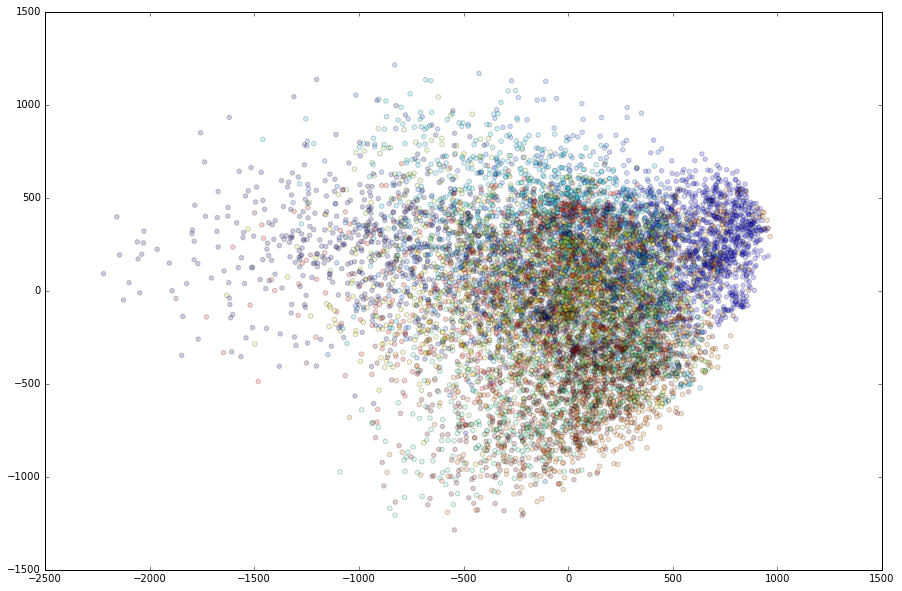

In [11]:
pyplot.figure(figsize=(15, 10))
pyplot.scatter(Y[:, 0], Y[:, 1], c=y_train, alpha=0.2)
pyplot.show()

### Применение PCA и kNN для $d \in \{1, \dots, 20\}, k \in \{1, \dots, 20\}$:

Функция, получающая на вход обучающую и тестовую выборки, применяющая pca для $d \in \{1, \dots, 20\}$, kNN для $k \in \{1, \dots, 20\}$ и возвращающая массив accuracies, где accuracies$[i][j]$ есть accuracy_score(y_test, y_predicted), y_predicted получен применением PCA с d=i и потом kNN с k=j:

In [13]:
def pcaKNN(X_train, y_train, X_test, y_test):
    accuracies = [[0 for i in range(20)] for j in range(20)]
    times = [[0 for i in range(20)] for j in range(20)]
    
    for d in range(1, 21):
        start_pca = datetime.now()
        
        pca = PCA(n_components=d)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        end_pca = datetime.now()
        time_pca = (end_pca - start_pca).total_seconds()
        
        for k in range(1, 21):
            start_knn = datetime.now()
            
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train_pca, y_train)
            
            y_predicted = knn.predict(X_test_pca)
            
            end_knn = datetime.now()
            time_knn = (end_knn - start_knn).total_seconds()
            
            d_k_accuracy = accuracy_score(y_test, y_predicted)
            
            accuracies[d - 1][k - 1] = d_k_accuracy
            times[d - 1][k - 1] = time_pca + time_knn
            
    return accuracies, times

Сгенерируем 5 случайных выборок X_train, y_train, X_test, y_test:

In [14]:
shuffledSamples = getShuffledSamples(5) 

Применим теперь к каждой сгенерированной выборке pcaKNN:

In [16]:
accuracies = [[] for i in range(5)]
times = [[] for i in range(5)]

for i in range(5):
    X_train = shuffledSamples[i][0]
    y_train = shuffledSamples[i][1]
    X_test = shuffledSamples[i][2]
    y_test = shuffledSamples[i][3]
    
    accuracies[i], times[i] = pcaKNN(X_train, y_train, X_test, y_test)

Для каждого d, k, усредним значение accuracy на пяти выборках и запишем в mean_accuracies$[d][k]$:

In [17]:
mean_accuracies = [[i for i in range(20)] for j in range(20)]
mean_times = [[i for i in range(20)] for j in range(20)]

for d in range(20):
    for k in range(20):
        for i in range(5):
            d_k_accuracies = [accuracies[x][d][k] for x in range(5)]
            d_k_times = [times[x][d][k] for x in range(5)]
            
            mean_accuracies[d][k] = np.mean(d_k_accuracies)
            mean_times[d][k] = np.mean(d_k_times)
            

### Найдем d и k, при которых accuracy максимально:

In [6]:
max_d = 0
max_k = 0
max_accuracy = 0

for d in range(20):
    for k in range(20):
        if mean_accuracies[d][k] > max_accuracy:
            max_d = d + 1
            max_k = k + 1
            max_accuracy = mean_accuracies[d][k]
            
print 'max accuracy:', max_accuracy
print 'corresponding d:', max_d
print 'corresponding k:', max_k

max accuracy: 0.874
corresponding d: 20
corresponding k: 8


Посмотрим, для каких k и d accuracy отличается от max_accuracy ненамного:

In [7]:
eps = 0.01

for d in range(20):
    for k in range(20):
        if abs(mean_accuracies[d][k] - max_accuracy) < eps:
            print 'accuracy:', mean_accuracies[d][k]
            print 'corresponding d:', d + 1
            print 'corresponding k:', k + 1

accuracy: 0.866
corresponding d: 17
corresponding k: 5
accuracy: 0.865
corresponding d: 17
corresponding k: 6
accuracy: 0.8646
corresponding d: 17
corresponding k: 7
accuracy: 0.8658
corresponding d: 17
corresponding k: 8
accuracy: 0.8672
corresponding d: 17
corresponding k: 9
accuracy: 0.8664
corresponding d: 17
corresponding k: 10
accuracy: 0.8666
corresponding d: 17
corresponding k: 11
accuracy: 0.866
corresponding d: 17
corresponding k: 12
accuracy: 0.8646
corresponding d: 17
corresponding k: 13
accuracy: 0.8666
corresponding d: 17
corresponding k: 14
accuracy: 0.8642
corresponding d: 17
corresponding k: 16
accuracy: 0.8686
corresponding d: 18
corresponding k: 4
accuracy: 0.8682
corresponding d: 18
corresponding k: 5
accuracy: 0.8678
corresponding d: 18
corresponding k: 6
accuracy: 0.8696
corresponding d: 18
corresponding k: 7
accuracy: 0.8674
corresponding d: 18
corresponding k: 8
accuracy: 0.8692
corresponding d: 18
corresponding k: 9
accuracy: 0.869
corresponding d: 18
correspon

Однако, для достаточно многих d, k.

### Визуализируем матрицы качества и времени работы в зависимости от d и k:

#### Качество (accuracy):

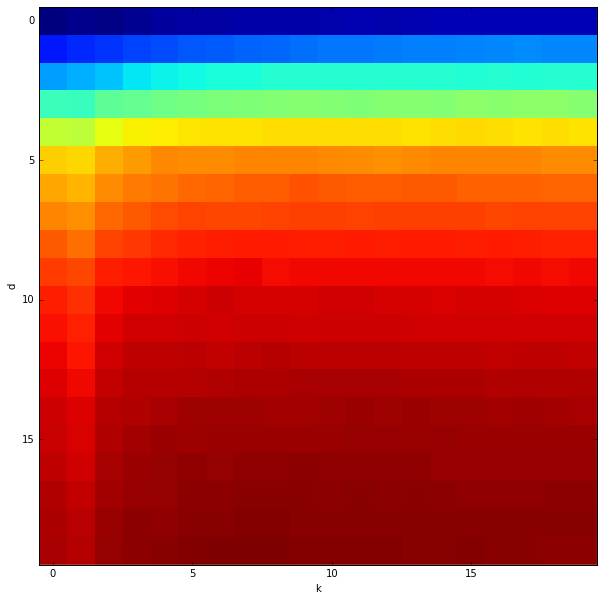

In [22]:
pyplot.figure(figsize=(10, 10))

pyplot.xlabel('k')
pyplot.ylabel('d')
pyplot.imshow(mean_accuracies, interpolation='none')

pyplot.show()

#### Время (time):

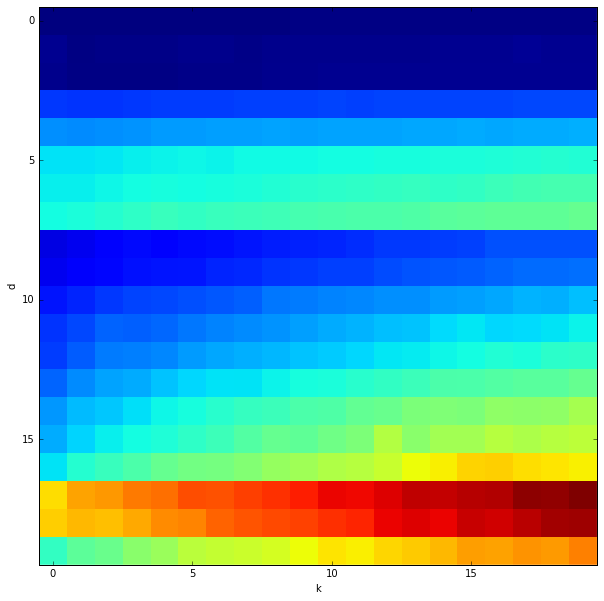

In [23]:
pyplot.figure(figsize=(10, 10))

pyplot.xlabel('k')
pyplot.ylabel('d')
pyplot.imshow(mean_times, interpolation='none')

pyplot.show()